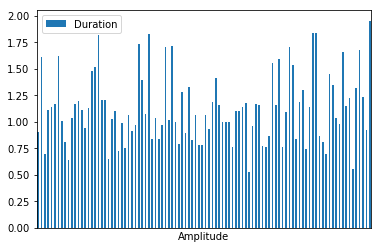

In [30]:
result.plot.bar(x='Amplitude', y='Duration')
plt.xticks([])
plt.show()

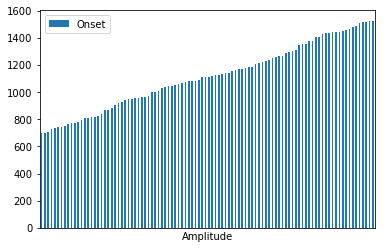

In [25]:
result.plot.bar(x='Amplitude', y='Onset')
plt.xticks([])
plt.show()

In [ ]:
result.plot.line()